In [141]:
%matplotlib widget

import matplotlib.pyplot as plt
from torch.autograd import grad
import itertools as it
from tqdm import tqdm
from torch import nn
import numpy as np
import torch

In [142]:
def roundrobin(*iterables):
    "Visit input iterables in a cycle until each is exhausted."
    # Recipe credited to George Sakkis
    n, nexts = len(iterables), it.cycle(iter(it).__next__ for it in iterables)
    while n:
        try:
            for next in nexts: yield next()
        except StopIteration: nexts = it.cycle(it.islice(nexts, n := n - 1))

In [143]:
device = torch.device('cpu')

n_in = 1
n_out = 1
n_hidden = [6, 6]

epochs = 2711
learning_rate = 3e-2

n_mesh = 100
train_bounds = (-8, 8)
train_mesh = torch.linspace(train_bounds[0], train_bounds[1], n_mesh, requires_grad=True, device=device)

h = train_mesh[1].item() - train_mesh[0].item()
integration_weights = torch.full((n_mesh, 1), h, device=device)

target = np.pi**-0.25 * torch.exp(-train_mesh**2 / 2).to(device)

In [144]:
class NQS(nn.Module):
    def __init__(self, n_in, n_out, n_hidden, weights = None, biases = None, activation_fun = None):
        super(NQS, self).__init__()

        self.n_in, self.n_out, self.n_hidden = n_in, n_out, n_hidden

        self.weights = [torch.rand(n_layer, n_prev, requires_grad=True) for n_layer, n_prev in zip(it.chain(n_hidden, [n_out]), it.chain([n_in], n_hidden))] if weights is None else weights
        self.biases = [torch.rand(n_layer, requires_grad=True) for n_layer in n_hidden] if biases is None else biases

        self.activation_fun = nn.Sigmoid() if activation_fun is None else activation_fun
        self.linear_ops = nn.ModuleList([nn.Linear(in_layer, out_layer, True) for in_layer, out_layer in zip(it.chain([n_in], n_hidden[:-1]), n_hidden)] + [nn.Linear(n_hidden[-1], n_out, False)])

        with torch.no_grad():
            for layer, weight, bias in zip(self.linear_ops, self.weights, self.biases):
                layer.weight = nn.Parameter(weight)
                layer.bias = nn.Parameter(bias)
            self.linear_ops[-1].weight = nn.Parameter(self.weights[-1])

    def forward(self, x):
        for op in roundrobin(self.linear_ops, it.repeat(self.activation_fun, len(self.linear_ops) - 1)):
            x = op(x)
        return x

In [145]:
neural_state = NQS(n_in, n_out, n_hidden, activation_fun=nn.LogSigmoid()).to(device)
print(neural_state)

NQS(
  (activation_fun): LogSigmoid()
  (linear_ops): ModuleList(
    (0): Linear(in_features=1, out_features=6, bias=True)
    (1): Linear(in_features=6, out_features=6, bias=True)
    (2): Linear(in_features=6, out_features=1, bias=False)
  )
)


In [146]:
optimizer = torch.optim.RMSprop(params=neural_state.parameters(), lr=learning_rate)

In [147]:
def loss_fn(x, x_data, x_data_sqr, nqs, integration_weights):
    psi, psi_sqr = nqs(x), nqs(x_data)**2
    dpsi_dx, *_ = grad(outputs=psi, inputs=x, grad_outputs=torch.ones_like(psi), create_graph=True)

    n = torch.tensordot(psi_sqr, integration_weights)
    u = torch.tensordot(x_data_sqr * psi_sqr, integration_weights) / n / 2 # Potential energy
    k = torch.tensordot(dpsi_dx**2, integration_weights) / n / 2 # Kinetic energy
    e = u + k # Total energy

    return e, u, k, psi, psi / torch.sqrt(n)

def tensor_stack(gen, op):
    result = next(gen)
    for t in gen: result = op(result, t)
    return result

def loss_fn(x, x_data, nqs, integration_weights, potentials):
    psi, psi_sqr = nqs(x), nqs(x_data)**2
    n = torch.tensordot(psi_sqr, integration_weights)

    dpsi_dx, *_ = grad(outputs=psi, inputs=x, grad_outputs=torch.ones_like(psi), create_graph=True)

    u = torch.tensordot(psi_sqr * tensor_stack(((x - potential)**2 for potential in potentials), torch.min), integration_weights) / n / 2
    k = torch.tensordot(dpsi_dx**2, integration_weights) / n / 2
    e = u + k

    return e, u, k, psi, psi / torch.sqrt(n)

In [148]:
def prepare_y(y, ax):
    y = y.detach().cpu().numpy()
    if np.average(y) < 0: y = -y
    ax.set_ylim(min(np.min(y), -0.05) * 1.1, np.max(y) * 1.1)
    return y

def create_plot(x):
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
    plt.subplots_adjust(wspace=0.3)
    ax1, ax2, ax3, *_ = ax

    # Overlap
    ax1.set_title('Normalized wave function')
    ax1.set_xlabel("$x$")
    ax1.set_ylabel("$\psi(x)$")
    ax1.plot(x, np.zeros_like(x), label='$\psi_\mathrm{NQS}$', color='b')
    ax1.plot(x, np.zeros_like(x), linestyle="--", label='$\psi_\mathrm{target}$', color='r')
    ax1.legend()

    # Wave function
    ax2.set_title('NQS wave function')
    ax2.set_xlabel("$x$")
    ax2.set_ylabel("$\psi(x)$")
    ax2.plot(x, np.zeros_like(x), label='$\psi_\mathrm{NQS}$', color='b')
    ax2.legend()

    # Loss
    ax3.set_title("Loss Function")
    ax3.set_xlabel("Epoch")
    ax3.set_ylabel("Cost")
    ax3.set_ylim(0, 1.2)
    ax3.plot([], label='$E$', color='b')
    ax3.plot([], label='$U$', color='orange')
    ax3.plot([], label='$K$', color='g')
    ax3.axhline(y=0.5, c='b', ls='--', label='$E_0$')
    ax3.axhline(y=0.25, c='g', ls='--', label='$U_0, K_0$')
    ax3.legend()

    fig.canvas.draw()
    return fig

def update_plot(i, x, target, psi, psi_normalized, loss, U, K, fig):
    ax1, ax2, ax3, *_ = fig.axes

    # Overlap
    wf = prepare_y(psi_normalized, ax1)
    ax1.lines[0].set_ydata(wf)
    ax1.lines[1].set_ydata(target)

    # Wave function
    wf = prepare_y(psi, ax2)
    ax2.lines[0].set_ydata(wf)

    # Loss
    ax3.set_xlim(0, i + 1)
    x = np.linspace(1, i + 1, i + 1)

    for line, y in zip(ax3.lines, [loss, U, K]):
        line.set_xdata(x)
        line.set_ydata(y)

    fig.canvas.draw()

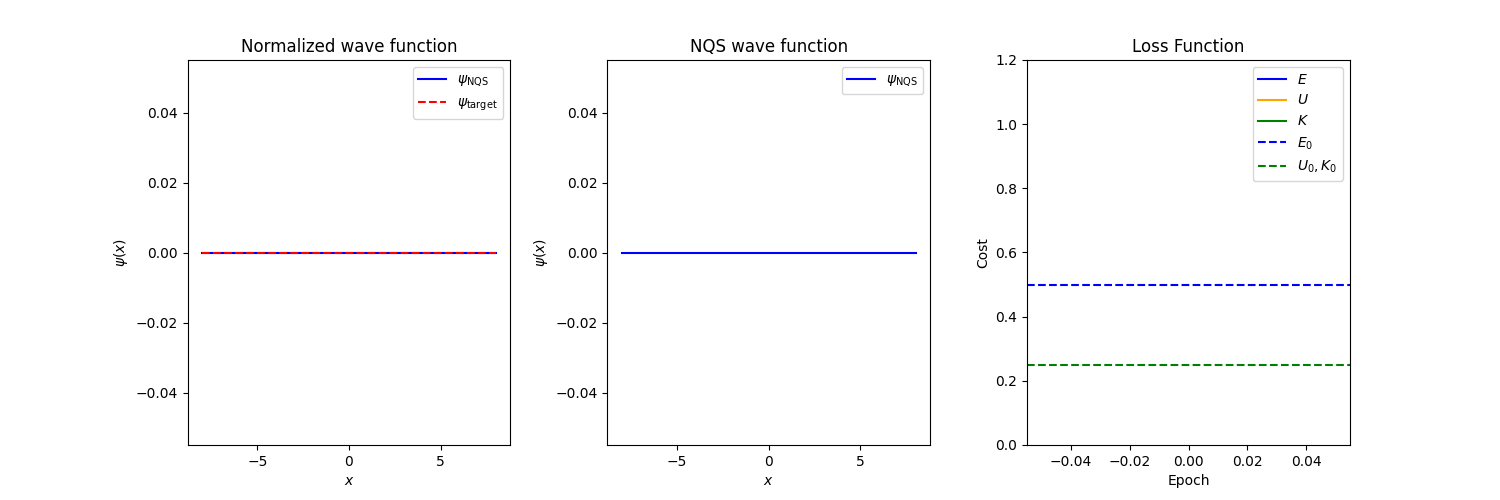

In [122]:
x = train_mesh.unsqueeze(1)
x_det = x.clone().detach()
x_det_sqr = x_det ** 2
fig = create_plot(x_det)

In [149]:
loss_accum, u_accum, k_accum = [], [], []
for i in tqdm(range(epochs), desc="Training the NQS..."):
    loss, u, k, psi, psi_normalized = loss_fn(x, x_det, neural_state, integration_weights, [-3, 0, 3])

    loss_accum.append(loss.item())
    u_accum.append(u.item())
    k_accum.append(k.item())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (i == epochs - 1) or (i % 100 == 0):
        update_plot(i, x, target.detach().numpy(), psi, psi_normalized, loss_accum, u_accum, k_accum, fig)

gs_energy, gs_wavefunction = loss_accum[-1], psi.clone().detach()

Training the NQS...: 100%|██████████| 2711/2711 [00:10<00:00, 256.82it/s]
